# Практическое ДЗ-2. Использование ALS для построения рекомендательной модели

В этой задаче мы построим простую рекомендательную модель на основе малоранговых приближений. 

In [1]:
import numpy as np
import scipy.sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt

plt.rcParams.update({
    "figure.figsize": (11, 7),
    "font.family" : "DejaVu Serif",
    "lines.linewidth" : 2,
    "lines.markersize" : 8,
    "xtick.labelsize" : 16,
    "ytick.labelsize" : 16,
    "legend.fontsize" : 16,
    "axes.titlesize" : 24,
    "axes.labelsize" : 16,
    # "text.usetex" : True
})

#%matplotlib inline

np.random.seed(0)

### Подготовка датасета
Загрузите датасет movielens10m с [grouplens.org](https://grouplens.org/datasets/movielens/10m/) или [disk.yandex.ru](https://disk.yandex.ru/d/HIjLehGZEcCRig) и положите архив в папку `data`. Нас будет интересовать файл `ratings.dat`, в котором собраны оценки пользователями различных фильмов с сервиса movielens.org. Вытащим этот файл из архива. Как можно узнать из соответствующей [странички](http://files.grouplens.org/datasets/movielens/ml-10m-README.html#file_desc), этот файл имеет формат `UserID::MovieID::Rating::Timestamp`. Сразу позаботимся, чтобы id пользователей и фильмов начинались с нуля (в самом файле индексация с единицы).

In [2]:
import zipfile
user_ids = []
movie_ids = []
ratings = []
with zipfile.ZipFile('data/ml-10m.zip') as archive:
    with archive.open('ml-10M100K/ratings.dat') as f:
        for l in f:
            user, movie, rating, _ = l.split(b'::')
            user_ids.append(int(user) - 1)
            movie_ids.append(int(movie) - 1)
            ratings.append(float(rating))

Составим матрицу рейтингов $A \in \mathbb R^{m \times n}$, индексируемую номером пользователем и номером фильма.
Для простоты мы будем делить отзывы только на положительные (`Rating >= 4` &mdash; $A_{i,j}=1$) и отрицательные (`Rating < 4` &mdash; $A_{i,j} = 0$), таким образом, матрица у нас получится состоящей только из нулей и единиц.
Обратите внимание, что матрица будет разреженной, так как средний пользователь оценил относительно мало фильмов. Поэтому мы будем пользоваться библиотекой `scipy.sparse`. Хранить матрицу мы будем в формате хранения разреженных матриц [CSR](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_(CSR,_CRS_or_Yale_format)), который поддерживает матричное умножение на numpy массивы: ```A @ X ```.

In [3]:
from scipy.sparse import csr_matrix
A = csr_matrix((np.array(ratings) >= 4, (user_ids, movie_ids)), dtype=np.float32)
A.eliminate_zeros()
print("Shape:", A.shape)
print("Ratio of nonzero elements:", A.nnz / (A.shape[0] * A.shape[1]))

Shape: (71567, 65133)
Ratio of nonzero elements: 0.0010738646228571796


Отделим некоторое количество пользователей для последующей проверки. Используем стандартное разбиение train/test 80/20.

In [4]:
n_users, n_movies = A.shape
n_test = int(n_users * 0.2)
n_train = n_users - n_test
idx = np.arange(n_users)
np.random.shuffle(idx)
test_idx, train_idx = idx[:n_test], idx[n_test:]
A_test, A_train = A[test_idx,:], A[train_idx,:]

Далее в задаче мы будем строить рекомендации пользователям на основе малорангового приближения матрицы $A$ (матрицы $A_{train}$ в рамках обозначений выше). 
Обратим внимание, что из-за ограничений по памяти мы не можем сформировать матрицу $A$ в виде numpy массива, а значит теряем доступ к ```np.linalg.svd```. Поэтому мы будем реализовывать метод ALS, в котором требуется только умножение на матрицы $A$ и $A^\top$, что поддерживается разреженными форматами хранения матриц (CSR, COO и тд).

### a. (35 баллов) Вычисление вспомогательных функционалов

  1. **(15 баллов)** Напомним, что в методе ALS решается задача минимизации функционала $f(U, V^\top) = \|A - UV^\top\|_F$ по всем $U \in \mathbb R^{m \times r}$ и $V  \in \mathbb R^{n \times r}$. Первым делом вам нужно будет написать функцию `als_functional` для вычисления оптимизируемого функционала $\|A - UV^\top\|_F$ для заданных $A$, $U$, $V^\top$. Заметьте, что прямое вычисление этой нормы &mdash; очень трудоёмкая задача, ведь разность будет плотной матрицей. Для того, чтобы эффективно вычислить норму разности, распишите $\|A - UV^\top\|_F^2$ через скалярное произведение $\langle X,Y \rangle_F = \mathrm{Tr}\,(X^\top Y)$, выполните алгебраические преобразования и покажите, как эффективно вычислить каждый член в полученном выражении. Имеется в виду, что ни на каком этапе вы не должны явно формировать плотные матрицы размеров `A.shape` (хотя numpy, скорее всего, и откажется аллоцировать 37 ГБ под такой массив).
  
  **Замечание**: не используйте циклы по ненулевым элементам разреженной матрицы $A$. Убедитесь, что в ваши формулы входит только умножение на матрицы $A$ или $A^\top$, на которые можно умножать посредством @; либо умножения сложности $O(mr^2), O(nr^2)$. Также отметим, что норма матрицы $A$ уже дана, заново её вычислять не надо. Везде считайте $r < m, n$.

$\|A-UV^\top\|_F^2 = \|A\|^2_F - 2\text{Tr}(A^\top U V^\top) + \|U V^\top\|_F^2 = \|A\|^2_F - 2\text{Tr}((V^\top A^\top) U) + \text{Tr}((V^\top V) (U^\top U))$

$B = V^\top A^\top = (A V)^\top - O(rnm)$ (умножение CSR справа на плотную) 

$B U - O(mr^2)$

$C=V^\top V - O(nr^2)$

$D=U^\top U - O(mr^2)$

$CD - O(r^3)$

In [5]:
def als_functional(A, A_norm, U, VT):
    """
        Input
            A: sparse 2D array
            A_norm: Frobenius norm of A
            U, VT: 2D arrays such that U @ VT approximates A
        Output
            ||A - U VT||_F
    """
    norm = A_norm**2 - 2 * np.trace((VT @ A.T) @ U) + np.trace((VT @ VT.T) @ (U.T @ U))
    
    return np.sqrt(np.clip(norm, a_min=0., a_max=None))

**Замечание:** Если вы не сможете выполнить следующие два пункта, можете их пропустить. Они не являются обязательными для следующих заданий.

  2. **(10 баллов)** Ещё одной метрикой сходимости ALS-процесса, помимо стабилизации самого функционала, может служить так называемое расстояние между подпространствами. Расстоянием между подпространствами $L_1 \subset \mathbb{R}^m$ и $L_2 \subset \mathbb{R}^m$ будем называть число $\|P(L_1) - P(L_2)\|_2$, где $P(L_i)$ &mdash; ортопроектор на $L_i$. Опишите алгоритм вычисления расстояния между двумя подпространствами $\mathrm{Im}(U_1)$ и $\mathrm{Im}(U_2)$ для заданных матриц $U_1, U_2 \in \mathbb{R}^{m \times r}$ с ортонормированными столбцами (т.е. $U_i^T U_i = I$). Алгоритм должен иметь сложность $O(mr^2)$. **Подсказка.** Воспользуйтесь фактом, что ортопроекторы являются матрицами малого ранга $r$, и техникой малоранговой арифметики, описанной на соответствующих лекции и семинаре.

$
\text{dist}(L_1, L_2) = \|U_1 U_1^\top - U_2 U_2^\top\| = 
\begin{bmatrix}
U_1 & -U_2
\end{bmatrix}
\begin{bmatrix}
U_1 & U_2
\end{bmatrix}^\top = A B^\top,\; A, B\in \mathbb{R}^{m\times 2r}
$

$
A = Q_A R_A;\; B = Q_B R_B - O(mr^2)
$

$
\|A B^\top\|_2 = \|Q_A R_A R_B^\top Q_B^\top\|_2 = \|R_A R_B^\top\|_2
$

$
C = R_A R_B^\top \in \mathbb{R}^{2r \times 2r}
$ - можно найти SVD за $O(r^3)$, далее выбрать наибольшее сигнулярное значение

Таким образом, общая сложность $O(mr^2)$ (при естественном условии $r < m$)

  3. **(10 баллов)** Напишите функцию `dist_between_subspaces`, принимающую на вход матрицы $U_1, U_2 \in \mathbb{R}^{m\times r}$ с ортонормированными столбцами, и возвращающую расстояние от $\mathrm{Im}(U_1)$ до $\mathrm{Im}(U_2)$. Сложность алгоритма должна быть $O(mr^2)$.

In [6]:
def dist_between_subspaces(U1, U2):
    """
        Input
            U1, U2: matrices with orthonormal columns
        Output
            Distance between Im(U1) and Im(U2)
    """
    A = np.concatenate((U1, -U2), axis=1)
    B = np.concatenate((U1, U2), axis=1)
    _, R_A = np.linalg.qr(A)
    _, R_B = np.linalg.qr(B)
    
    return np.linalg.norm(R_A @ R_B.T, ord=2)  # it's computed via svd in O(r^3), np.linalg.svdvals(R_A @ R_B.T)[0]

### b. (30 баллов) Метод ALS
Реализуйте метод ALS (alternating least squares) с ортогонализацией (см. лекции).

Вам будет необходимо вернуть две матрицы: $U$ и $V^\top$, образующие скелетное разложение результирующего приближения; где $U$ имеет ортонормированные столбцы. Также нужно вернуть 3 списка:


*   Список значений функционала $f(U_k, V^\top_k) = \|A - U_k V^\top_k\|_F$

*   Список изменений значений функционала $\delta_k = f(U_{k-1}, V^\top_{k-1}) - f(U_k, V^\top_k)$

*   Список растояний между пространствами $\|P(U_{k-1}) - P(U_{k})\|_2$

В качестве критерия остановки будем использовать величину $\delta_k$. При значении $\delta_k \le tolerance$ алгоритм должен остановиться. При указании `debug=True` печатайте номер текущей итерации и последнюю $\delta_k$, а также любую дополнительную интересную вам информацию. 

Используйте реализованные выше функции. Для вычисления фробениусовой нормы разреженной матрицы используйте `norm` из `scipy.sparse.linalg`.

**Замечание:** Если вы не реализовали dist_between_subspaces, то вместо третьего списка возращайте None.

In [7]:
from scipy.sparse.linalg import norm as sparse_norm


def ALS(A, rank, tolerance=1e-2, debug=False):
    """
        Input
            A: 2D m x n numpy array
            rank: required rank of the approximation
            tolerance: stop when delta_k is less or equal to it
            debug: print debug information on each iteration
            
        Output
            U, VT: m x rank, rank x n numpy arrays forming skeleton decomposition;
                   columns of matrix U are orthonormal
            fs: list of f(U_k, VT_k)
            deltas: list of f(U_{k-1}, VT_{k-1}) - f(U_k, VT_k)
            dists: list of distances between Im(U_{k-1}) and Im(U_k)
    """
    m, n = A.shape
    U = np.random.randn(m, rank)
    V = np.random.randn(n, rank)
    
    A_norm = sparse_norm(A, ord='fro')
    
    fs = []
    deltas = []
    dists = [np.inf]
    
    idx = 0
    
    U_prev = U
    V_prev = V
    while (dists[-1] > tolerance):
        V, _ = np.linalg.qr(V_prev)
        U = A @ V
        U, _ = np.linalg.qr(U)
        V = A.T @ U
        
        fs.append(als_functional(A, A_norm, U, V.T))
        if idx >= 1:
            deltas.append(fs[-2] - fs[-1])
            dists.append(dist_between_subspaces(U_prev, U))
        
        U_prev = U.copy()
        V_prev = V.copy()
        
        idx += 1
        if debug:
            print(f"Iteration: {idx}; dist: {dists[-1] if idx > 1 else "-"}")
    
    dists = dists[1:]
    
    return U, V.T, fs, deltas, dists

Запустим метод на матрице `A_train` и посмотрим на убывание расстояния между соседними подпространствами от номера итерации.

In [8]:
rank = 30
U_als, VT_als, fs, deltas, dists = ALS(A_train, rank, 0.1, debug=True)

Iteration: 1; dist: -
Iteration: 2; dist: 0.8685724354237785
Iteration: 3; dist: 0.5093479673530437
Iteration: 4; dist: 0.3483103705746771
Iteration: 5; dist: 0.26474063555694455
Iteration: 6; dist: 0.1999301490175758
Iteration: 7; dist: 0.1522262409062241
Iteration: 8; dist: 0.11850939515203202
Iteration: 9; dist: 0.09921728137461912


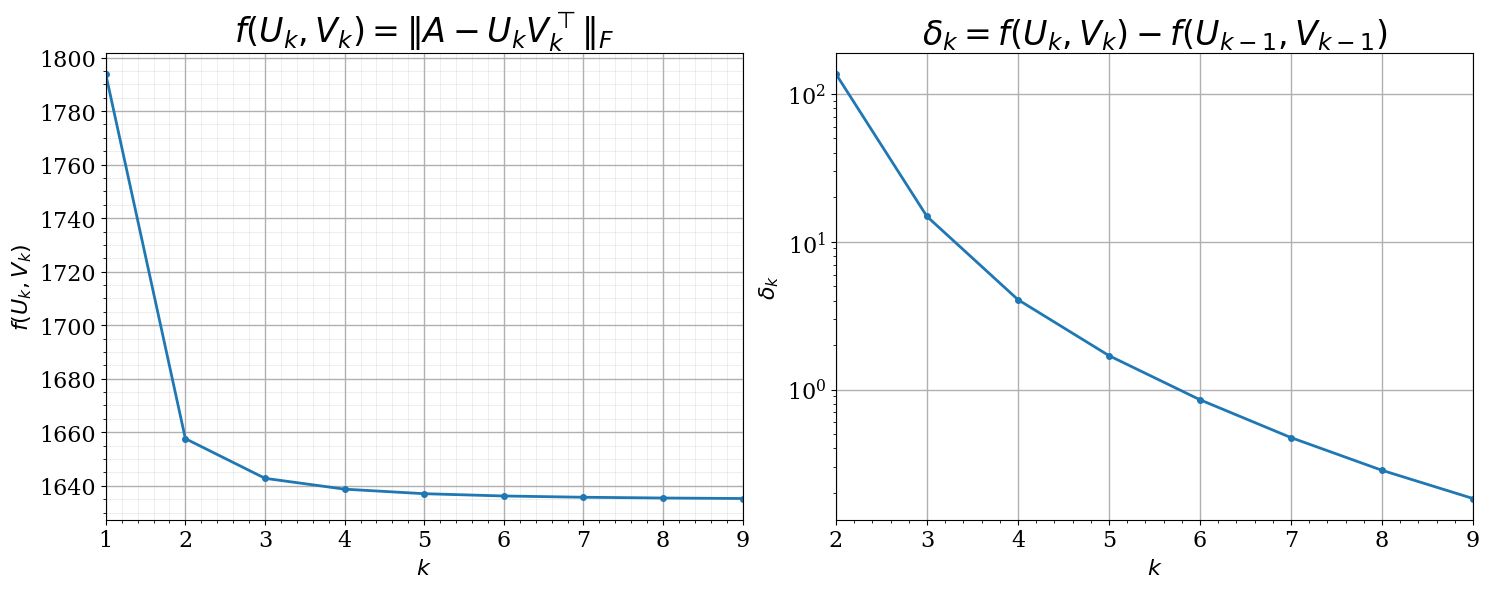

In [9]:
fig, axs = plt.subplots(figsize=(15, 6), ncols=2)

axs[0].set_title(r"$f(U_k, V_k) = \|A-U_kV_k^\top\|_F$")
axs[0].plot(np.arange(1, len(fs) + 1), fs, marker='.')
axs[0].set_xlabel('$k$'); axs[0].set_ylabel(r'$f(U_k, V_k)$')
axs[0].minorticks_on()
axs[0].set_xlim([1, len(fs)])
axs[0].grid(True, lw=1, which='major'); axs[0].grid(True, alpha=0.3, lw=0.5, which='minor')

axs[1].set_title(r"$\delta_k = f(U_k, V_k) - f(U_{k-1}, V_{k-1})$")
axs[1].semilogy(np.arange(2, len(deltas) + 2), deltas, marker='.')
axs[1].set_xlabel('$k$'); axs[1].set_ylabel(r'$\delta_k$')
axs[1].minorticks_on()
axs[1].set_xlim([2, len(deltas) + 1])
axs[1].grid(True, lw=1, which='major'); axs[0].grid(True, alpha=0.3, lw=0.5, which='minor')

fig.tight_layout()

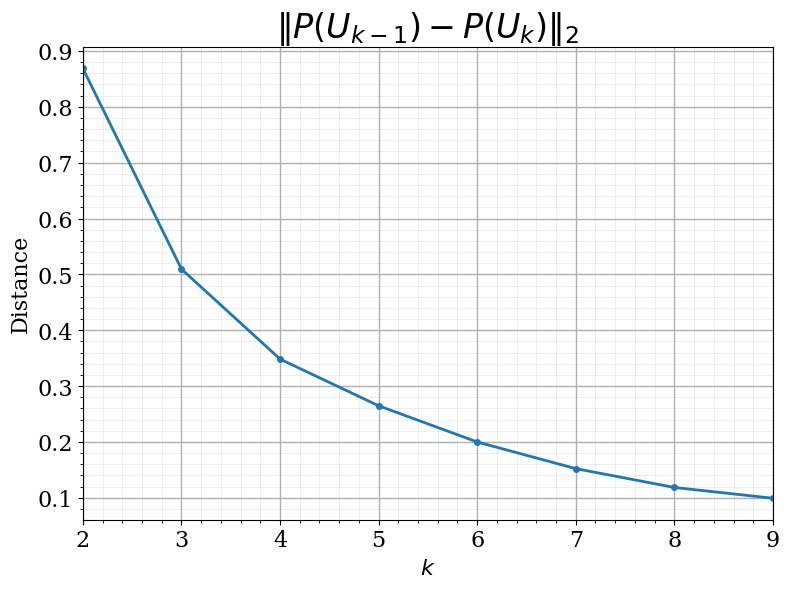

In [10]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_title(r"$\|P(U_{k-1}) - P(U_{k})\|_2$")
ax.plot(np.arange(2, len(dists) + 2), dists, marker='.')
ax.set_xlabel('$k$'); ax.set_ylabel('Distance')
ax.minorticks_on()
ax.set_xlim([2, len(dists) + 1])
ax.grid(True, lw=1, which='major'); ax.grid(True, alpha=0.3, lw=0.5, which='minor')
fig.tight_layout()

### c. (10 баллов) Сравнение с рандомизированным SVD и разреженным SVD

Примените рандомизированное SVD из sklearn, а также SVD из scipy, поддерживающее разреженные матрицы (используйте тот же ранг 30, что и для ALS). Сравните все три результата по значению функционала.

In [11]:
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

A_norm = sparse_norm(A_train)

U_rand, S_rand, VT_rand = randomized_svd(A_train, n_components=rank)
U_sparse, S_sparse, VT_sparse = svds(A_train, k=rank)

In [12]:
print(
    f"Randomized SVD: {als_functional(A_train, A_norm, U_rand, S_rand[:, None] * VT_rand):.5f}\n"
    f"Sparse SVD:     {als_functional(A_train, A_norm, U_sparse, S_sparse[:, None] * VT_sparse):.5f}\n"
    f"ALS:            {als_functional(A_train, A_norm, U_als, VT_als):.5f}"
)

Randomized SVD: 1634.51855
Sparse SVD:     1634.40405
ALS:            1635.24911


Решение, полученное ALS лишь незначительно хуже решений через разреженное и рандомизированное SVD. Лучшее значенеи функционала у разреженного SVD.

## d. (25 баллов) Построение рекомендаций
  1. **(10 баллов)** Научимся рекомендовать пользователям из тестовой группы фильмы на основе части их оценок. Напишем функцию `recommend`, которая будет принимать матрицу $V^\top$ из нашей модели, матрицу `(user_id, movie_id) -> binary rating` (то есть того же формата, что и наша основная матрица `A`), а также число `n_recs` &mdash; количество фильмов, которые мы хотим порекомендовать. Возвращать функция будет top-`n_recs` рекомендаций, то есть `n_recs` фильмов, которые могут пользователю понравиться, в порядке убывания предсказанной привлекательности.

  Чтобы построить рекомендацию, необходимо ортогонально спроецировать вектор, соответствующий новому пользователю (про которого мы знаем часть оценок), на пространство $L$, образуемое строками матрицы $V^\top$. Иными словами, мы должны взять ближайший вектор из $L$. Он будет содержать предсказанные нашей моделью рейтинги. Дальше дело техники :) Но не забудьте, что `known_ratings` содержит векторы, соответствующие не одному пользователю, а батчу из `batch_size` пользователей. Хотя и (слава numpy) код остаётся почти дословно такой же.  **Подсказка:** используйте функцию `np.argsort`.

In [13]:
def recommend(VT, known_ratings, n_recs):
    """
        Input
            VT: 2D numpy array
            known_rating: sparse batch_size x n_movies array
            n_recs: requested number of recommendations
            
        Output
            recs: batch_size x n_recs array of movies to recommend, with descending predicted rating
    """
    Q, _ = np.linalg.qr(VT.T)
    proj = (known_ratings @ Q) @ Q.T  # (user_id, movie_id)
    recs = np.argsort(proj, axis=1)[:, -1:-(n_recs + 1):-1]

    return recs

Для проверки нашей модели для каждого пользователя из тестовой выборки оценим так называемый **hit rate**. Для этого выбросим одну из его оценок, вызовем функцию `recommend` и посмотрим, попал ли выкинутый фильм в подборку. Если попал &mdash; это hit, иначе не hit. Для того, чтобы эффективно проделать этот эксперимент на всех тестовых данных, сделаем следующее: разобьём тестовую матрицу на батчи по 500 пользователей и будем предсказывать сразу для целого батча. Вычислим вектор размера `n_test`, где для каждого пользователя указано, на каком месте в рекомендованной подборке оказался скрытый фильм (или число `n_recs`, если скрытого фильма не нашлось среди top-n  рекомендаций).

In [14]:
from scipy.sparse import find

def evaluate_model(VT, A_test, n_recs, batch_size=500):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users
            n_recs: requested number of recommendations
            batch_size: number of users to build recommendations for in a single call to recommend

        Output
            hit_idx: list of n_test ints: place of secret movie 
                     in top-n_recs recommendations (or n_recs if it is missing)
    """
    secrets = []
    nonempty_users = []
    A_test = A_test.copy()
    for user in range(A_test.shape[0]):
        _, good, _ = find(A_test[user,:])
        if len(good) == 0:
            continue
        nonempty_users.append(user)
        secret = np.random.choice(good, 1)[0]
        A_test[user, secret] = 0
        secrets.append(secret)
    hit_idx = []
    for i in range(0, len(nonempty_users), batch_size):
        # Build recomendations for a batch.
        recommendations = recommend(VT, A_test[nonempty_users[i:i + batch_size], :], n_recs + 1)
        # Place secret in the last column so that the following .argmax finds it.
        recommendations[:,-1] = secrets[i: i + batch_size]
        # Find secret among the recommendations and place its index into batch_hit_idx.
        batch_hit_idx = (recommendations == np.array([secrets[i:i + batch_size]]).T).argmax(1)
        hit_idx += batch_hit_idx.tolist()
    return hit_idx

  2. **(15 баллов)** Научимся вычислять hit rate для данной модели и заданного количества top-n рекомендаций. Для этого напишем функцию `get_hit_rates`, которая будет принимать $V^\top$ из нашей модели, вектора оценок для новых пользователей `A_test` и список натуральных чисел `n_recs`. Для каждого из этих чисел необходимо посчитать средний hit rate по всем пользователям из `A_test`, то есть, например, для `n_recs == [5, 10, 20]` нужно вернуть список средних хитрейтов для top-5, top-10 и top-20. **Обратите внимание:** вызвать функцию `evaluate_model` нужно только один раз.

In [15]:
def get_hit_rates(VT, A_test, n_recs):
    """
        Input
            VT: 2D numpy array representing the rating model
            A_test: sparse n_test x n_movies array corresponding to new users 
            n_recs: list of ints: number of top recomendations to evaluate hit rate for
        Output
            hit_rates: list of float: hit rate for each element of n_recs
    
    """
    hit_rates = np.zeros(len(n_recs), dtype=float)
    hit_idx = np.array(evaluate_model(VT=VT, A_test=A_test, n_recs=max(n_recs)))
    
    for idx, top_n in enumerate(n_recs):
        hit_rates[idx] = np.sum(hit_idx < top_n) / len(hit_idx)
        
    return hit_rates
    

Проверьте себя: вычислите хитрейт на top-10 рекомендаций для Sparse SVD ранга 30. Чтобы вычисления рекомендаций были побыстрее, используйте не всю матрицу `A_test`, а, например, первые 1000 строк. Хитрейт должен получится в районе 12-15%. Самое время подебажить своё решение, если числа сильно расходятся.

In [16]:
get_hit_rates(VT=VT_sparse, A_test=A_test[:1000, :], n_recs=[10])

array([0.12269939])

Теперь можно построить графики зависимости hit rate от количества рекомендаций, а также от ранга модели. Сравним результаты, которые дают три алгоритма: ALS, Sparse SVD и рандомизированный SVD.

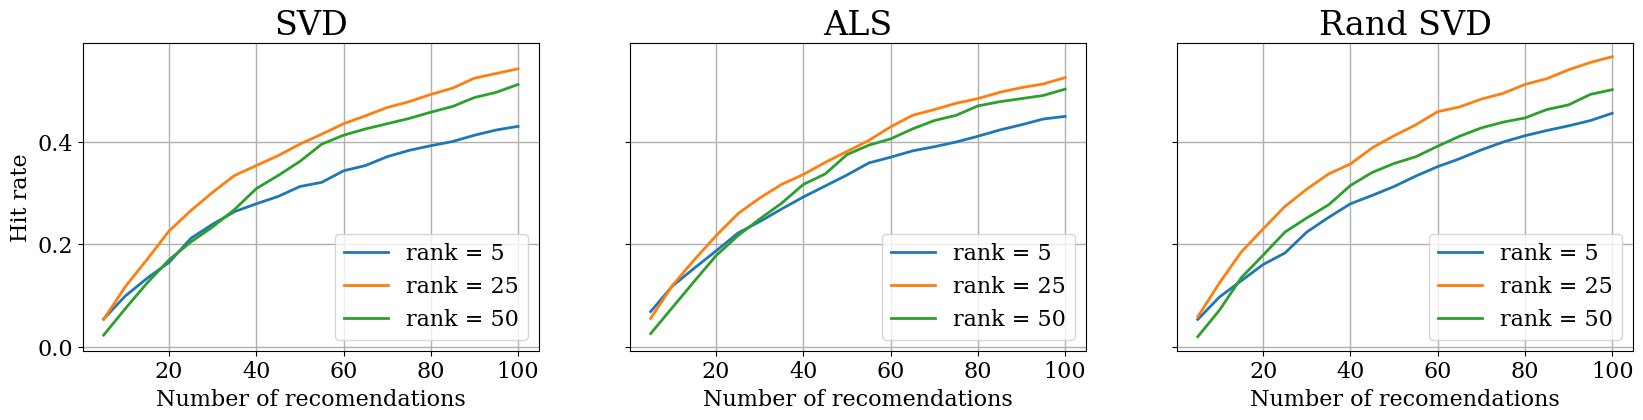

In [17]:
from scipy.sparse.linalg import svds

n_recs = list(range(5, 101, 5))

plt.rcParams.update({'font.size': 14})
_, (ax_svd, ax_als, ax_rand) = plt.subplots(1,3,figsize=(20, 4),sharey=True)

ax_svd.set_title("SVD")
ax_svd.set_ylabel("Hit rate")
ax_als.set_title("ALS")
ax_rand.set_title("Rand SVD")
for rank in [5, 25, 50]:
    _, _, VT_svd = svds(A_train, k=rank)
    _, VT_als, _, _, _ = ALS(A_train, rank)
    _, _, VT_rand = randomized_svd(A_train, rank)
    for VT, ax in zip([VT_svd, VT_als, VT_rand], [ax_svd, ax_als, ax_rand]):
        ax.set_xlabel("Number of recomendations")
        hit_rates = get_hit_rates(VT, A_test[:1000,:], n_recs)
        line, = ax.plot(n_recs, hit_rates)
        line.set_label('rank = {}'.format(rank))
        ax.grid(True, lw=1, which='major'); ax.grid(True, alpha=0.3, lw=0.5, which='minor')
        ax.legend()

Какой ранг приближения оказался оптимальным для нашей модели в случае каждого алгоритма?

Sparse SVD: для большого числа рекомендаций (более 20) ранги 25 и 50 значительно превосходят ранг 5 в качестве предсказаний, при этом для большого числа рекомендаций hit rate'ы 25 и 50-го рангов практически совпадают

ALS: для малого числа предсказаний качество алгоритма с рангом 5 превосходит более выскоие ранги, однако уже начиная с 15 рекомендайий лучший hit rate у ранга 25, далее 50 и 5 

Rand SVD: начиная с 15 рекомендаций лучшим качеством обладает ранг 25, далее 50 и 5.
 
Более правильно было бы усреднять большое число запусков в связи со случайным выбором фильмов для предсказывания рейтингов, но общее наблюдение увеличения hit rate при росте числа рекомендаций и заметно лучшего качества ранга 25 для достаточно большого числа (~15 и больше) рекомендаций наблюдается для всех алгоритмов. 50 ранг начинает превосходить ранг 5 начиная с нескольких десятков рекомендаций. Предпочтительнее во всех случаях использовать ранг 25 и рассматривать хотя бы несколько десятков рекомендаций (к 80 практически достигает 0.5), учитывая тот факт, что для малого числа предсказаний hit rate всех алгоритмов низок и не превышает 0.15 для 10 и менее рекомендаций. 

## Бонус. Higher-order SVD (100 баллов)

**В бонусе разрешается использовать циклы только по размерности.**

1. (**20 баллов**) Напишите функцию ```tuck2full(G, Us)```, возвращающую полный тензор размера $n_1\times n_2 \times \ldots \times n_d$ по его разложению Таккера. Предусмотрите, чтобы функция работала и в случае, если в матрицах $U_1,U_2, \ldots, U_d$ строк меньше, чем столбцов. Вместо циклов используйте функцию ```np.einsum```.

In [18]:
# it's far more convenient to use tensordot here. 
def tuck2full(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            A: d-dimensional numpy array of the size (n1, n2, ..., nd)
    """
    A = G
    for U in Us:
        A = np.linalg.tensordot(A, U, axes=((0, ), (1, )))

    return A

In [19]:
# test for d = 3
g = np.random.randn(10000, 2, 3, 4, 42)
a = np.random.randn(2, 10000)
b = np.random.randn(3, 2)
c = np.random.randn(7, 3)
d = np.random.randn(9, 4)
e = np.random.randn(24, 42)

In [20]:
%%timeit
# some time is spent on auxilary computations
np.einsum('ijklm,ai,bj,ck,dl,em->abcde', g, a, b, c, d, e, optimize='optimal')

12.1 ms ± 348 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [21]:
%%timeit
tuck2full(g, (a, b, c, d, e))

4.56 ms ± 84.2 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Протестируем алгоритм:

In [22]:
r1 = np.einsum('ijklm,ai,bj,ck,dl,em->abcde', g, a, b, c, d, e, optimize='optimal')
r2 = tuck2full(g, (a, b, c, d, e))
np.allclose(r1, r2)

True

2. (**35 баллов**) Реализуйте higher-order SVD алгоритм для нахождения разложения Таккера данного $d$-мерного массива $A\in\mathbb{R}^{n_1\times \ldots \times n_d}$. Алгоритм должен находить малоранговое приближение $A$ с относительной точностью не хуже $\varepsilon$ во Фробениусовой норме. Функция должна вернуть ядро и факторы Таккера у приближающего тензора. Для получения ядра Таккера будет удобно воспользоваться функцией ```tuck2full```.

Найдем для каждой развертки $(A_{(m)}), m=\overline{1,d}$, SVD разложение, сингулярные числа равны $\sigma_1^{(m)} \geq \sigma_2^{(m)} \geq ...$

Ошибка аппроксимации усеченным HOSVD ограничена энергией наименьших сингулярных чисел:

$
\|A - A_{\text{hosvd}}\|_F \leq \sqrt{\sum\limits_{n=1}^{d}\sum\limits_{i >r_n} (\sigma_i^{(n)})^2}
$

На основе это оценки, для аппроксимации с ошибкой не хуже $\varepsilon$, можем потребовать:

$
\sum\limits_{i >r_n} (\sigma_i^{(n)})^2 \leq \dfrac{\varepsilon^2}{d}
$

In [23]:
def factor_m_flattening_U(A, m, eps):
    r"""
        Input
            A: d-dimensional numpy array
            A_norm: frobenius norm of A
            m: the index of mode for m-flattening of A (A_m)
            eps: accuracy of Tucker approximation
            
        Output
            Uk: left singulat values of truncated SVD for A_m.    
    """
    d = A.ndim
    transpose_axes = np.arange(d)
    transpose_axes[[0, m]] = transpose_axes[[m, 0]]
    
    flat_shape = (A.shape[m], np.prod(A.shape) // A.shape[m])
    
    A_m = np.reshape(np.transpose(A, axes=transpose_axes), shape=flat_shape, order='f')
    
    U, S, _ = np.linalg.svd(A_m, full_matrices=False)
    
    eps_thres_sqr = (eps / np.sqrt(d))**2
    
    if S[-1]**2 > eps_thres_sqr:
        Uk = U
    else:
        k = np.argmax(np.cumsum(S[::-1]**2) > eps_thres_sqr)
        Uk = U[:, :-(k)]
    
    return Uk

def hosvd(A, eps):
    """
        Input
            A: d-dimensional numpy array
            eps: accuracy of Tucker approximation

        Output
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)
    """    
    Us = tuple([factor_m_flattening_U(A, m, eps) for m in range(A.ndim)])
    
    G = tuck2full(A, tuple([U.T for U in Us]))
    
    return G, Us

In [24]:
def print_hosvd_info(A, A_hosvd, A_hosvd_factors):
    """
        Input
            A: d-dimensional numpy array
            A_hosvd: HOSVD approximation of A
            A_hosvd_factors: tuple of HOSVD factors of A: (G, U1, ..., Ud)
            
        Output
            Prints shapes of HOSVD factors and ||A - A_hosvd||_F
    """
    print(
        f"G.shape = {A_hosvd_factors[0].shape}",
        "\n".join(f'U{i}.shape = {A_hosvd_factors[1][i].shape}' for i in range(len(A_hosvd_factors[1]))),
        f"||A - A_hosvd||_F = {np.linalg.norm(A - A_hosvd):.5g}", sep='\n'
    )

Пример: согласованность c SVD (d=2)

In [25]:
r = 7
m, n = 50, 80
A2 = np.random.randn(m, r) @ np.random.randn(r, n)  # rank(A2) = 7

U2, S2, V2T = np.linalg.svd(A2, full_matrices=False)

U2 = U2[:, :r]
S2 = S2[:r]
V2T = V2T[:r, :]

In [26]:
A2_hosvd_factors = hosvd(A2, 1e-6)
A2_hosvd = tuck2full(*A2_hosvd_factors)
print_hosvd_info(A2, A2_hosvd, A2_hosvd_factors)

G.shape = (7, 7)
U0.shape = (50, 7)
U1.shape = (80, 7)
||A - A_hosvd||_F = 1.9104e-13


3. (**5 баллов**) Примените функцию ```hosvd``` к тензору размера $25 \times 50 \times 75 \times 100$ с элементами
$$
    a_{ijkl} = \frac{1}{i + j + k + l + 1}, \quad i,j,k,l=0,1,...
$$
для малорангового приближения с точностью $10^{-6}$. Массив $A$ соберите с помощью функции ```np.meshgrid```. Напечатайте получившиеся ранги и относительную ошибку полученного малорангового приближения (для этого используйте функцию ```tuck2full```).

In [27]:
dims = (25, 50, 75, 100)
A = 1 / (sum(np.meshgrid(*(np.arange(d) for d in dims), indexing='ij')) + 1)

In [28]:
A_hosvd_factors = hosvd(A, eps=1e-6)

In [29]:
A_hosvd = tuck2full(*A_hosvd_factors)

In [30]:
print_hosvd_info(A, A_hosvd, A_hosvd_factors)

G.shape = (10, 11, 11, 11)
U0.shape = (25, 10)
U1.shape = (50, 11)
U2.shape = (75, 11)
U3.shape = (100, 11)
||A - A_hosvd||_F = 5.5609e-07


4. (**15 баллов**) Докажите, что норма Фробениуса приближения HOSVD $A'$ совпадает с её ядром Таккера $G'$:

$$
  \|A'\|_F = \|G'\|_F
$$

$\square$ Пусть $A' = [G;\, U_1, U_2,...U_d]$. На леции было доказано, что $A'_{(m)} = U_m G_{(m)} (U_d \otimes ... \otimes U_{m+1} \otimes U_{m-1} \otimes ... \otimes U_1)^\top$. Так как развертка матрицы лишье переупорядочивает все ее элементы, норма Фробениуса $A'_{(m)}$ и $A'$ равны: $\|A'\|_F = \|A'_{(m)}\|_F$. То же верно и для ядра Таккера: $\|G'\|_F = \|G'_{(m)}\|_F$. Известно, что кронекерово произведение ортогональных матриц ортогонально. Остается заметить, что норма Фробениуса является унитарно-инвариантной. Таким образом, $\|A'\|_F = \|G'\|_F$, что и требовалось. $\blacksquare$

5. (**25 баллов**) Для заданного таккеровского разложения напишите функцию вычисления его нормы. Примените ее к разложению тензора размера 10000 x 10000 x 10000 со случайными Таккеровскими факторами и ядром мультилинейного ранга (10, 10, 10).

$ A = [G;\, U_1, U_2,...U_d]$ &mdash; разложение Таккера. $\|A\|_F = \|\text{vec}(A)\|_F$.

$\text{vec}(A) = (U_d \otimes...\otimes U_1) \text{vec}(G) = ((Q_d R_d) \otimes...\otimes (Q_1 R_1)) \text{vec}(G) = 
(Q_d \otimes...\otimes Q_1) (R_d \otimes...\otimes R_1) \text{vec}(G)$.

$\|\text{vec}(A)\|_F = \|(Q_d \otimes...\otimes Q_1) (R_d \otimes...\otimes R_1) \text{vec}(G)\|_F = \|(R_d \otimes...\otimes R_1) \text{vec}(G)\|_F = \|[G;\, R_1, ..., R_d]\|_F$

In [31]:
def tuck_norm(G, Us):
    """
        Input
            G: d-dimensional numpy array - Tucker core of size (r1, r2, ..., rd)
            Us: tuple of 2D numpy arrays - Tucker factors of size (n1, r1), ..., (nd, rd)

        Output
            norm: Frobenius norm of A = [G; U1 ... Ud]
    """
    Rs = tuple(np.linalg.qr(U)[1] for U in Us)
    
    return np.linalg.norm(tuck2full(G, Rs))
    

In [32]:
m, n = 10, 10000
G = np.random.randn(m, m, m)
Us = tuple(np.random.randn(n, m) for _ in range(G.ndim))

print(f'{tuck_norm(G, Us) = :.3g}')

tuck_norm(G, Us) = 3.12e+07


Проверим корректность алгоритма на малом тензоре:

In [35]:
G = np.random.randn(2, 3, 4, 5, 6)
Us = tuple(np.random.randn(42, ni) for ni in G.shape)

In [36]:
norm_opt = tuck_norm(G, Us) 
norm_direct = np.linalg.norm(tuck2full(G, Us))
print(f'{norm_opt - norm_direct = :.3g}')

norm_opt - norm_direct = 2.91e-10
